# Data Challenge 2022 : Predicting odor compound concentrations

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D,Input
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adadelta
from tensorflow.keras.utils import to_categorical
from math import *
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.layers import SimpleRNN
from keras.layers import LSTM

from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
#from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.callbacks import EarlyStopping

In [3]:
input_train = pd.read_csv('Data\input_train_wide_format.csv', sep=',', index_col=0)
output_train=pd.read_csv('Data\output_train_wide_format.csv', sep=',', index_col=0)
input_test=pd.read_csv('Data\input_test_wide_format_b10i0rq.csv', sep=',', index_col=0)

In [4]:
features=input_train.columns
#X_train = input_train.to_numpy()
Y_train = output_train.to_numpy()
#print(np.shape(X_train), np.shape(Y_train))
print(features)

Index(['weekday-48', 'weekday-47', 'weekday-46', 'weekday-45', 'weekday-44',
       'weekday-43', 'weekday-42', 'weekday-41', 'weekday-40', 'weekday-39',
       ...
       'land_cover_class_HRI-10', 'land_cover_class_HRI-9',
       'land_cover_class_HRI-8', 'land_cover_class_HRI-7',
       'land_cover_class_HRI-6', 'land_cover_class_HRI-5',
       'land_cover_class_HRI-4', 'land_cover_class_HRI-3',
       'land_cover_class_HRI-2', 'land_cover_class_HRI-1'],
      dtype='object', length=2064)


In [5]:
len(features)//48

43

Text(0, 0.5, 'Concentration so2 (μg / m³)')

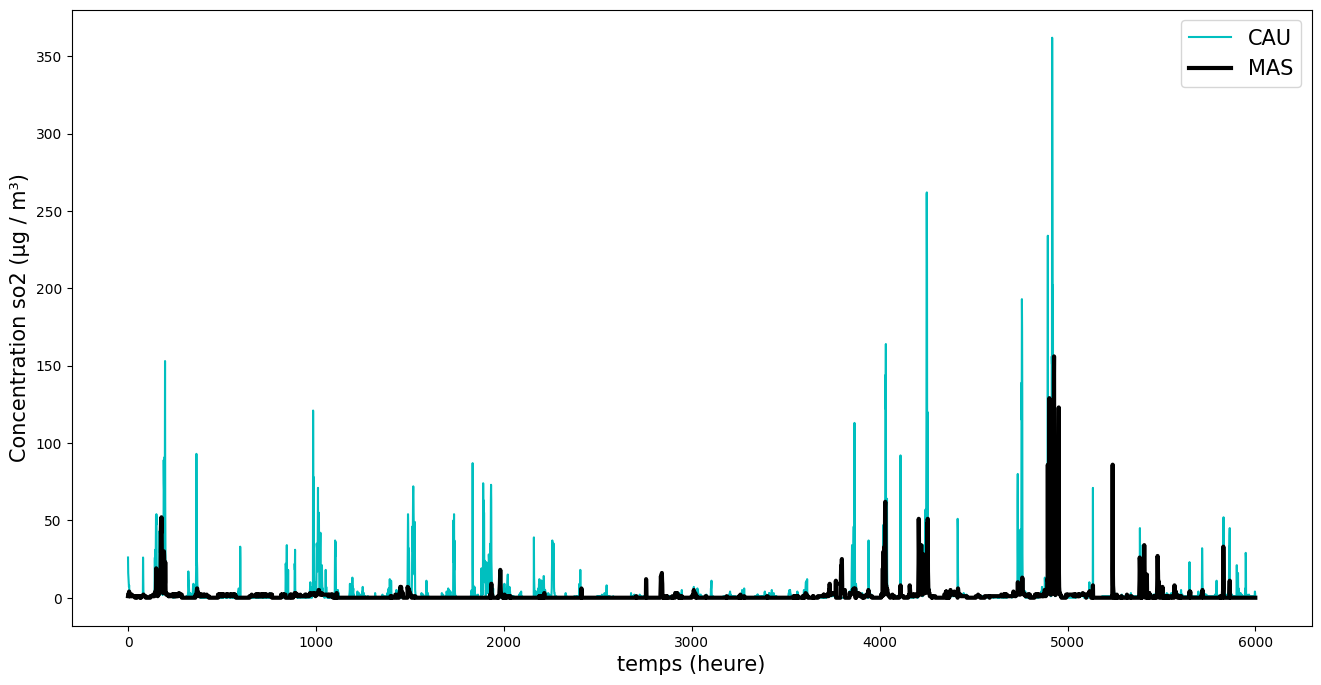

In [6]:
#Visualisation des concentrations en SO2
import matplotlib.pyplot as plt

n_heures=6000
heure_start=0 #ligne de départ dans le tableau output

#stations1=['HRI', 'HVH', 'STA','CAU','GOR','HAR']
stations1=['CAU']
so2_labels_1=['SO2_' + s + '-48' for s in stations1]

input_index=np.arange(heure_start+48, heure_start+48+n_heures, 1)
output_index=np.arange(heure_start, heure_start+n_heures, 1)
Y_vis = output_train.loc[output_index]['SO2_MAS+0'].to_numpy()
X_vis = input_train.loc[input_index][so2_labels_1].to_numpy()

Colors=['c','b','darkviolet','lime','r','fuchsia','k']

plt.figure(figsize=(16,8))
x=np.arange(heure_start, heure_start+len(Y_vis))
for i in range(len(stations1)):
  plt.plot(x,X_vis[:,i], c=Colors[i], label=stations1[i])
plt.plot(x,Y_vis, c=Colors[-1], label='MAS', linewidth=3)
plt.legend(prop={'size': 15})
plt.xlabel('temps (heure)', size=15)
plt.ylabel('Concentration so2 (μg / m³)', size=15)

Text(0, 0.5, 'log(1+SO2_MAS)')

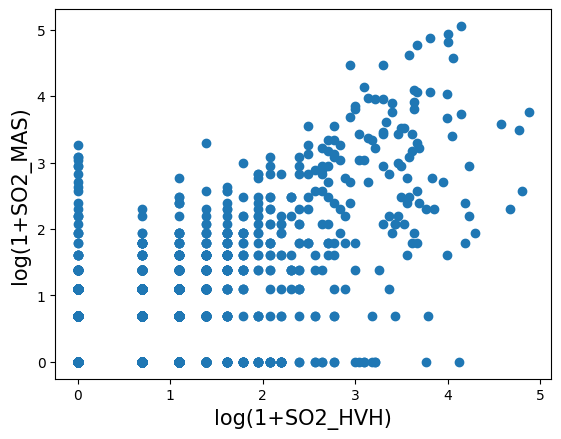

In [7]:
n_heures=6000
heure_start=0 #ligne de départ dans le tableau output

stations1=['HVH']
so2_labels_1=['SO2_' + s + '-48' for s in stations1]

input_index=np.arange(heure_start+48, heure_start+48+n_heures, 1)
output_index=np.arange(heure_start, heure_start+n_heures, 1)
Y_vis = output_train.loc[output_index]['SO2_MAS+0'].to_numpy()
X_vis = input_train.loc[input_index][so2_labels_1].to_numpy()

plt.scatter(np.log(1+X_vis), np.log(1 + Y_vis))
plt.xlabel('log(1+SO2_HVH)', size=15)
plt.ylabel('log(1+SO2_MAS)', size=15)

Text(0, 0.5, 'Concentration so2 (μg / m³)')

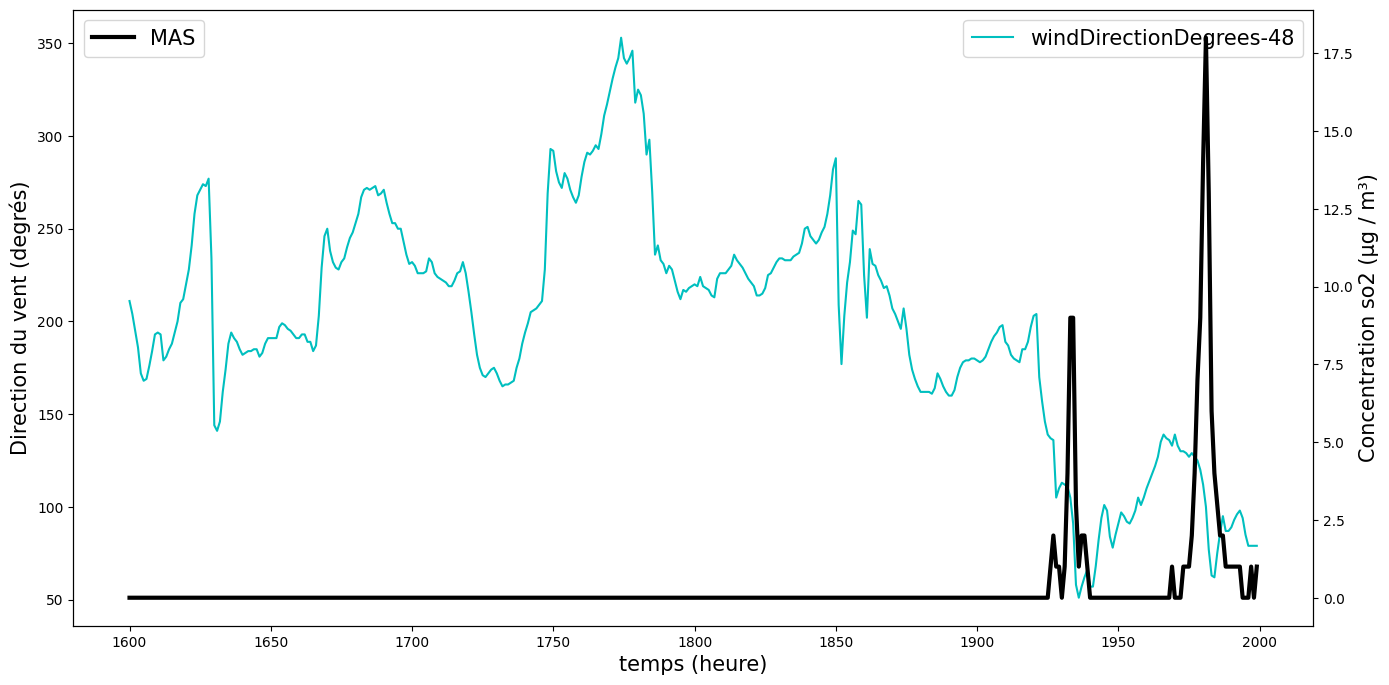

In [8]:
#Visualisation d'une ou plusieurs features au choix

n_heures=400
heure_start=1600 #ligne de départ dans le tableau output

selected_features_vis=['windDirection','SO2_GORR'] #features qu'on veut afficher
sf_bool_vis=[any(sf in f for sf in selected_features_vis) and f[-3:]=='-48' for f in features]
selected_features_vis=features[sf_bool_vis]

input_index=np.arange(heure_start+48, heure_start+48+n_heures, 1)
output_index=np.arange(heure_start, heure_start+n_heures, 1)
Y_vis = output_train.loc[output_index]['SO2_MAS+0'].to_numpy()
X_vis = input_train.loc[input_index][selected_features_vis].to_numpy()
'''scaler_x_vis = MinMaxScaler(feature_range=(0, 1)) # normalisation avec max(Y_vis) pour conserver l'intensité des pics, 1 pour la lisibilité
X_vis = scaler_x_vis.fit_transform(X_vis)'''
Y_vis = Y_vis

Colors=['c','b','darkviolet','lime','r','fuchsia','orange','yellow']

fig,ax= plt.subplots(figsize=(16,8))
x=np.arange(heure_start, heure_start+len(Y_vis))
for i in range(len(selected_features_vis)):
  ax.plot(x,X_vis[:,i], c=Colors[i], label=selected_features_vis[i])
ax2=ax.twinx()
ax2.plot(x,Y_vis, c='k', label='MAS', linewidth=3)
ax.legend(loc='upper right', prop={'size': 15})
ax2.legend(loc='upper left', prop={'size': 15})
ax.set_xlabel('temps (heure)', size=15)
ax.set_ylabel('Direction du vent (degrés)', size=15)
ax2.set_ylabel('Concentration so2 (μg / m³)', size=15)

In [9]:
input_train.loc[1768:1828]['windSpeedKph-48']

ID
1768    13.7
1769    12.6
1770    12.4
1771    13.0
1772    14.7
        ... 
1824     8.7
1825     6.4
1826     6.3
1827     8.4
1828     7.3
Name: windSpeedKph-48, Length: 61, dtype: float64

In [10]:
#Choix des features qui nous intéressent
selected_features_name=['SO2_CAU', 'windSpeedKph', 'windDirectionDegrees'] #features qu'on doit inclure
sf_bool=[any(sf in f for sf in selected_features_name) for f in features]
selected_features=features[[x for x in sf_bool]] #rajouter not pour exclure

sf_indices=np.isin(features,selected_features)

X_train_simplifie=input_train[selected_features].fillna(value=0)
X_train_simplifie=X_train_simplifie.to_numpy()

'''Land_class_dict={'Continuous urban fabric' : 1, 'Discontinuous urban fabric' : 2, 'Green urban areas' : 3, 'Port areas' : 4} #on remplace les land cover class par des entiers
for j in range(1,48*6+1):
  for i in range(len(X_train_simplifie)):
    if X_train_simplifie[i,-j] in Land_class_dict.keys():
      X_train_simplifie[i,-j]= Land_class_dict[X_train_simplifie[i,-j]]'''

#nan_index=[not(any([isnan(x) for x in X_train_simplifie[i]])) for i in range(len(X_train_simplifie))]
#X_train_simplifie=X_train_simplifie[nan_index]
#Y_train1=Y_train[nan_index]

n=len(selected_features)
input_train.shape
#np.unique(input_train[["land_cover_class_HVC-48","land_cover_class_HVC-47","land_cover_class_HVC-46","land_cover_class_HVC-45","land_cover_class_HVC-44","land_cover_class_HVC-43","land_cover_class_HVC-42","land_cover_class_HVC-41","land_cover_class_HVC-40","land_cover_class_HVC-39","land_cover_class_HVC-38","land_cover_class_HVC-37","land_cover_class_HVC-36","land_cover_class_HVC-35","land_cover_class_HVC-34","land_cover_class_HVC-33","land_cover_class_HVC-32","land_cover_class_HVC-31","land_cover_class_HVC-30","land_cover_class_HVC-29","land_cover_class_HVC-28","land_cover_class_HVC-27","land_cover_class_HVC-26","land_cover_class_HVC-25","land_cover_class_HVC-24","land_cover_class_HVC-23","land_cover_class_HVC-22","land_cover_class_HVC-21","land_cover_class_HVC-20","land_cover_class_HVC-19","land_cover_class_HVC-18","land_cover_class_HVC-17","land_cover_class_HVC-16","land_cover_class_HVC-15","land_cover_class_HVC-14","land_cover_class_HVC-13","land_cover_class_HVC-12","land_cover_class_HVC-11","land_cover_class_HVC-10","land_cover_class_HVC-9","land_cover_class_HVC-8","land_cover_class_HVC-7","land_cover_class_HVC-6","land_cover_class_HVC-5","land_cover_class_HVC-4","land_cover_class_HVC-3","land_cover_class_HVC-2","land_cover_class_HVC-1","land_cover_class_HAR-48","land_cover_class_HAR-47","land_cover_class_HAR-46","land_cover_class_HAR-45","land_cover_class_HAR-44","land_cover_class_HAR-43","land_cover_class_HAR-42","land_cover_class_HAR-41","land_cover_class_HAR-40","land_cover_class_HAR-39","land_cover_class_HAR-38","land_cover_class_HAR-37","land_cover_class_HAR-36","land_cover_class_HAR-35","land_cover_class_HAR-34","land_cover_class_HAR-33","land_cover_class_HAR-32","land_cover_class_HAR-31","land_cover_class_HAR-30","land_cover_class_HAR-29","land_cover_class_HAR-28","land_cover_class_HAR-27","land_cover_class_HAR-26","land_cover_class_HAR-25","land_cover_class_HAR-24","land_cover_class_HAR-23","land_cover_class_HAR-22","land_cover_class_HAR-21","land_cover_class_HAR-20","land_cover_class_HAR-19","land_cover_class_HAR-18","land_cover_class_HAR-17","land_cover_class_HAR-16","land_cover_class_HAR-15","land_cover_class_HAR-14","land_cover_class_HAR-13","land_cover_class_HAR-12","land_cover_class_HAR-11","land_cover_class_HAR-10","land_cover_class_HAR-9","land_cover_class_HAR-8","land_cover_class_HAR-7","land_cover_class_HAR-6","land_cover_class_HAR-5","land_cover_class_HAR-4","land_cover_class_HAR-3","land_cover_class_HAR-2","land_cover_class_HAR-1","land_cover_class_CAU-48","land_cover_class_CAU-47","land_cover_class_CAU-46","land_cover_class_CAU-45","land_cover_class_CAU-44","land_cover_class_CAU-43","land_cover_class_CAU-42","land_cover_class_CAU-41","land_cover_class_CAU-40","land_cover_class_CAU-39","land_cover_class_CAU-38","land_cover_class_CAU-37","land_cover_class_CAU-36","land_cover_class_CAU-35","land_cover_class_CAU-34","land_cover_class_CAU-33","land_cover_class_CAU-32","land_cover_class_CAU-31","land_cover_class_CAU-30","land_cover_class_CAU-29","land_cover_class_CAU-28","land_cover_class_CAU-27","land_cover_class_CAU-26","land_cover_class_CAU-25","land_cover_class_CAU-24","land_cover_class_CAU-23","land_cover_class_CAU-22","land_cover_class_CAU-21","land_cover_class_CAU-20","land_cover_class_CAU-19","land_cover_class_CAU-18","land_cover_class_CAU-17","land_cover_class_CAU-16","land_cover_class_CAU-15","land_cover_class_CAU-14","land_cover_class_CAU-13","land_cover_class_CAU-12","land_cover_class_CAU-11","land_cover_class_CAU-10","land_cover_class_CAU-9","land_cover_class_CAU-8","land_cover_class_CAU-7","land_cover_class_CAU-6","land_cover_class_CAU-5","land_cover_class_CAU-4","land_cover_class_CAU-3","land_cover_class_CAU-2","land_cover_class_CAU-1","land_cover_class_MAS-48","land_cover_class_MAS-47","land_cover_class_MAS-46","land_cover_class_MAS-45","land_cover_class_MAS-44","land_cover_class_MAS-43","land_cover_class_MAS-42","land_cover_class_MAS-41","land_cover_class_MAS-40","land_cover_class_MAS-39","land_cover_class_MAS-38","land_cover_class_MAS-37","land_cover_class_MAS-36","land_cover_class_MAS-35","land_cover_class_MAS-34","land_cover_class_MAS-33","land_cover_class_MAS-32","land_cover_class_MAS-31","land_cover_class_MAS-30","land_cover_class_MAS-29","land_cover_class_MAS-28","land_cover_class_MAS-27","land_cover_class_MAS-26","land_cover_class_MAS-25","land_cover_class_MAS-24","land_cover_class_MAS-23","land_cover_class_MAS-22","land_cover_class_MAS-21","land_cover_class_MAS-20","land_cover_class_MAS-19","land_cover_class_MAS-18","land_cover_class_MAS-17","land_cover_class_MAS-16","land_cover_class_MAS-15","land_cover_class_MAS-14","land_cover_class_MAS-13","land_cover_class_MAS-12","land_cover_class_MAS-11","land_cover_class_MAS-10","land_cover_class_MAS-9","land_cover_class_MAS-8","land_cover_class_MAS-7","land_cover_class_MAS-6","land_cover_class_MAS-5","land_cover_class_MAS-4","land_cover_class_MAS-3","land_cover_class_MAS-2","land_cover_class_MAS-1","land_cover_class_GOR-48","land_cover_class_GOR-47","land_cover_class_GOR-46","land_cover_class_GOR-45","land_cover_class_GOR-44","land_cover_class_GOR-43","land_cover_class_GOR-42","land_cover_class_GOR-41","land_cover_class_GOR-40","land_cover_class_GOR-39","land_cover_class_GOR-38","land_cover_class_GOR-37","land_cover_class_GOR-36","land_cover_class_GOR-35","land_cover_class_GOR-34","land_cover_class_GOR-33","land_cover_class_GOR-32","land_cover_class_GOR-31","land_cover_class_GOR-30","land_cover_class_GOR-29","land_cover_class_GOR-28","land_cover_class_GOR-27","land_cover_class_GOR-26","land_cover_class_GOR-25","land_cover_class_GOR-24","land_cover_class_GOR-23","land_cover_class_GOR-22","land_cover_class_GOR-21","land_cover_class_GOR-20","land_cover_class_GOR-19","land_cover_class_GOR-18","land_cover_class_GOR-17","land_cover_class_GOR-16","land_cover_class_GOR-15","land_cover_class_GOR-14","land_cover_class_GOR-13","land_cover_class_GOR-12","land_cover_class_GOR-11","land_cover_class_GOR-10","land_cover_class_GOR-9","land_cover_class_GOR-8","land_cover_class_GOR-7","land_cover_class_GOR-6","land_cover_class_GOR-5","land_cover_class_GOR-4","land_cover_class_GOR-3","land_cover_class_GOR-2","land_cover_class_GOR-1","land_cover_class_HRI-48","land_cover_class_HRI-47","land_cover_class_HRI-46","land_cover_class_HRI-45","land_cover_class_HRI-44","land_cover_class_HRI-43","land_cover_class_HRI-42","land_cover_class_HRI-41","land_cover_class_HRI-40","land_cover_class_HRI-39","land_cover_class_HRI-38","land_cover_class_HRI-37","land_cover_class_HRI-36","land_cover_class_HRI-35","land_cover_class_HRI-34","land_cover_class_HRI-33","land_cover_class_HRI-32","land_cover_class_HRI-31","land_cover_class_HRI-30","land_cover_class_HRI-29","land_cover_class_HRI-28","land_cover_class_HRI-27","land_cover_class_HRI-26","land_cover_class_HRI-25","land_cover_class_HRI-24","land_cover_class_HRI-23","land_cover_class_HRI-22","land_cover_class_HRI-21","land_cover_class_HRI-20","land_cover_class_HRI-19","land_cover_class_HRI-18","land_cover_class_HRI-17","land_cover_class_HRI-16","land_cover_class_HRI-15","land_cover_class_HRI-14","land_cover_class_HRI-13","land_cover_class_HRI-12","land_cover_class_HRI-11","land_cover_class_HRI-10","land_cover_class_HRI-9","land_cover_class_HRI-8","land_cover_class_HRI-7","land_cover_class_HRI-6","land_cover_class_HRI-5","land_cover_class_HRI-4","land_cover_class_HRI-3","land_cover_class_HRI-2","land_cover_class_HRI-1"]])

(6089, 2064)

In [11]:
#transformation des features coordonnées et vent
from copy import deepcopy

selected_features_name=['SO2_HRI', 'SO2_HVH', 'SO2_STA', 'SO2_CAU', 'SO2_GOR', 'SO2_CAU','windSpeedKph'] #features qu'on doit inclure

L=input_train.loc[1]

def transforme_vent(input, selected_features_name):
  selected_features_name1=deepcopy(selected_features_name)
  stations=['HRI', 'HVH', 'MAS', 'STA', 'CAU', 'GOR', 'HAR']
  X_wind=input[['windDirectionDegrees-'+str(i) for i in range(48,0,-1)]]
  X_wind1=X_wind.to_numpy()
  azimut_dict={'HRI' : 252.4, 'STA' : 278.5, 'HVH' : 300.5, 'HAR' : 80.0, 'GOR' : 85.6, 'CAU' : 75.3}
  for s in stations:
    if (any(s in f for f in selected_features_name)):
      X_wind_temp=np.abs(np.cos((X_wind1-azimut_dict[s])*(np.pi/360))) #360 au lieu de 180 pour valoir 1 en 0 et 0 en pi
      #X_wind_temp=1-(1/360)*(np.min(np.abs(X_wind1-azimut_dict[s]), np.abs(np.abs(X_wind1-azimut_dict[s])-360)))
      selected_features_name1.append('windDirection_' + s)
      for i in range(len(X_wind_temp[0])):
        X_wind['windDirection_' + s + '_' + str(48-i)]=X_wind_temp[:,i]
  return pd.merge(input, X_wind, how='outer'), selected_features_name1 #on rajoute les nouvelles colonnes au dataset

X_wind, selected_features_name1 = transforme_vent(input_train, selected_features_name)
print(X_wind.shape)
features=X_wind.columns

sf_bool=[any(sf in f for sf in selected_features_name1) for f in features]
selected_features=features[[x for x in sf_bool]] #rajouter not pour exclure

sf_indices=np.isin(features,selected_features)

X_train_simplifie=X_wind[selected_features].fillna(value=0)
X_train_simplifie=X_train_simplifie.to_numpy()

C:\Users\Gatien\AppData\Local\Temp\ipykernel_12540\1706295713.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_wind['windDirection_' + s + '_' + str(48-i)]=X_wind_temp[:,i]
C:\Users\Gatien\AppData\Local\Temp\ipykernel_12540\1706295713.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_wind['windDirection_' + s + '_' + str(48-i)]=X_wind_temp[:,i]
C:\Users\Gatien\AppData\Local\Temp\ipykernel_12540\1706295713.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

(6089, 2304)


In [12]:
#@title
model = Sequential()
model.add(Dense(units=64,input_dim=n))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dense(units=12))

#adam = Adam(learning_rate=0.01)
sgd = SGD(learning_rate=0.01)
model.compile(optimizer=sgd, loss='mean_squared_error',
                metrics=['accuracy'])

In [13]:
#@title
#model.fit(X_train_simplifie, Y_train1, epochs=10, batch_size=64)

Réseau de neurones récurrents

In [14]:
X_train_scaled, X_test_scaled, Y_train_scaled, Y_test_scaled = train_test_split(X_train_simplifie, Y_train, train_size=0.8, test_size=0.2)

scaler_x, scaler_y = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))
scaler_x1, scaler_y1 = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_x.fit_transform(X_train_scaled)
X_test_scaled = scaler_x1.fit_transform(X_test_scaled)
X_train_scaled=np.reshape(X_train_scaled, (X_train_scaled.shape[0], X_train_scaled.shape[1]//48, 48))
X_test_scaled=np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1]//48, 48))
Y_train_scaled = scaler_y.fit_transform(Y_train_scaled)
scaler_y1.fit_transform(Y_test_scaled)

callback = EarlyStopping(monitor='val_loss', patience=20)

model_rnn = Sequential()
model_rnn.add(LSTM(units=32, input_shape= (X_train_scaled.shape[1], X_train_scaled.shape[2]), recurrent_dropout=0.2))
model_rnn.add(Dense(units=12))
model_rnn.summary()

adam=Adam(learning_rate=0.001)
model_rnn.compile(loss='mean_squared_error', optimizer=adam)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                10368     
                                                                 
 dense_2 (Dense)             (None, 12)                396       
                                                                 
Total params: 10,764
Trainable params: 10,764
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_rnn.fit(X_train_scaled, Y_train_scaled, epochs=100, batch_size=64, validation_split=0.08, callbacks=[callback])

Epoch 1/100
71/71 [==============================] - 6s 18ms/step - loss: 0.0082 - val_loss: 0.0033
Epoch 2/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 3/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0027
Epoch 4/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 5/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0026
Epoch 6/100
71/71 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 7/100
71/71 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 8/100
71/71 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0025
Epoch 9/100
71/71 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 10/100
71/71 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import mean_squared_error
Y_predicted1=model_rnn.predict(X_test_scaled)
model_rnn.evaluate(X_test_scaled,Y_predicted1)

Y_predicted1 = scaler_y1.inverse_transform(Y_predicted1)
mean_squared_error(Y_test_scaled, Y_predicted1)

39/39 [==============================] - 0s 3ms/step - loss: 0.0000e+00


14.975050097250389

In [ ]:
#X_test1= X_wind[selected_features].fillna(value=0)
X_wind = transforme_vent(input_test, selected_features_name)[0]
X_test1=X_wind[selected_features].fillna(value=0)
X_test1= X_test1.to_numpy()

'''for j in range(1,48*6+1):
  for i in range(len(X_test1)):
    if X_test1[i,-j] in Land_class_dict.keys():
      X_test1[i,-j]= Land_class_dict[X_test1[i,-j]]'''

X_test= scaler_x.fit_transform(X_test1)

X_test=np.reshape(X_test, (X_test.shape[0], X_test.shape[1]//48, 48))
print(X_test.shape)
print(X_train_scaled.shape)

Y_predicted_scaled = model_rnn.predict(X_test)
Y_predicted = scaler_y.inverse_transform(Y_predicted_scaled)

Y_predicted_labels=['SO2_MAS+' + str(i) for i in range(12)]
Y_predicted_df = pd.DataFrame(Y_predicted, columns=Y_predicted_labels, index= [i for i in range(1, len(Y_predicted)+1)])
Y_predicted_df.index.name='ID'

Y_predicted_df.to_csv('LSTM_so2.csv')

(168, 11, 48)
(4871, 11, 48)
6/6 [==============================] - 0s 4ms/step


<ipython-input-16-4f5c2f08ed1e>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_wind['windDirection_' + s + '_' + str(48-i)]=X_wind_temp[:,i]
<ipython-input-16-4f5c2f08ed1e>:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_wind['windDirection_' + s + '_' + str(48-i)]=X_wind_temp[:,i]


In [ ]:
X_wind.shape

(168, 2304)

In [ ]:
L=input_train.loc[1]
stations=['HRI', 'HVH', 'MAS', 'STA', 'CAU', 'GOR', 'HAR']
x_coord_label, y_coord_label = ['x_wgs84_' + s + '-1' for s in stations], ['y_wgs84_' + s + '-1' for s in stations]
x_coord, y_coord = L[x_coord_label], L[y_coord_label]

coord = pd.DataFrame({'x_wgs84' : [x for x in x_coord], 'y_wgs_84' : [y for y in y_coord]}, index = stations)

#coord.to_csv('stations_coordinates.csv')
coord

,x_wgs84,y_wgs_84
HRI,0.100703,49.489631
HVH,0.100861,49.514214
MAS,0.142706,49.498300
STA,0.084614,49.503861
CAU,0.175731,49.503908
GOR,0.232486,49.502731
HAR,0.201694,49.505000


In [ ]:
#réseau de neurones LSTM avec seulement les concentrations

stations1=['HRI', 'HVH', 'STA','CAU','GOR','HAR']
so2_labels=['SO2_' + s + '-' + str(i) for s in stations1 for i in range(48,0,-1)]
X_so2= input_train[so2_labels].to_numpy()
X_so2=np.reshape(X_so2, (X_so2.shape[0], X_so2.shape[1]//48, 48))
print(X_so2.shape)

model_rnn1 = Sequential()
model_rnn1.add(LSTM(units=32, input_shape= (X_so2.shape[1], X_so2.shape[2]), recurrent_dropout=0.2))
model_rnn1.add(Dense(units=12))

adam=Adam(learning_rate=0.001)
model_rnn1.compile(loss='mean_squared_error', optimizer=adam)

model_rnn1.summary()

(6089, 6, 48)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                10368     
                                                                 
 dense_3 (Dense)             (None, 12)                396       
                                                                 
Total params: 10,764
Trainable params: 10,764
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model_rnn1.fit(X_so2, Y_train, epochs=100, batch_size=1024, validation_split=0.08)

In [ ]:
X_test_so2= input_test[so2_labels].to_numpy()
X_test_so2=np.reshape(X_test_so2, (X_test_so2.shape[0], X_test_so2.shape[1]//48, 48))
print(X_test_so2.shape)

Y_predicted_so2= model_rnn1.predict(X_test_so2)

Y_predicted_so2_df = pd.DataFrame(Y_predicted_so2, columns=Y_predicted_labels, index= [i for i in range(1, len(Y_predicted_so2)+1)])
Y_predicted_so2_df.index.name='ID'

Y_predicted_so2_df.to_csv('LSTM_so2.csv')

(168, 6, 48)
6/6 [==============================] - 0s 3ms/step


In [ ]:
model_rnn1.evaluate(X_test_so2,Y_predicted_so2)

6/6 [==============================] - 0s 4ms/step - loss: 0.0000e+00


0.0

In [ ]:
#Direction moyenne du vent
V_label=['windDirectionDegrees-'+str(i) for i in range(48,0,-1)]
V=input_train[V_label].to_numpy()

nan_index=[not(any([isnan(x) for x in V[i]])) for i in range(len(V))]
V1=V[nan_index]
#[np.mean(x) for x in V1]

In [ ]:
np.shape(input_train)

(6089, 2064)

In [ ]:
# Optimisation du modèle
# Feature selection

def create_model_rnn(X2):
  model_rnn2 = Sequential()
  model_rnn2.add(LSTM(units=30, input_shape= (X2.shape[1], X2.shape[2]), recurrent_dropout=0.2))
  model_rnn2.add(Dense(units=12))

  adam=Adam(learning_rate=0.001)
  model_rnn2.compile(loss='mean_squared_error', optimizer=adam)

  return model_rnn2

#Choix des features qui nous intéressent
features1=[features[48*i] for i in range(len(features)//48)]
features1=[features1[i][0:-3] for i in range(len(features1))]
 
#l'algorithme RFECV ne fonctionnant pas avec des dataset de dimension 3, on écrit une fonction à la main :

def transformation_df(X,Y): #prépare le dataframe pour la RFE (normalisation, remplacement des NA)
  features=X.columns
  X=X[features].fillna(value=0)
  X=X.to_numpy()
  Y=Y.fillna(value=0)
  Y=Y.to_numpy()

  #on remplace les land cover class par des entiers
  Land_class_dict={'Continuous urban fabric' : 1, 'Discontinuous urban fabric' : 2, 'Green urban areas' : 3, 'Port areas' : 4} 
  for j in range(1,48*6+1):
    for i in range(len(X)):
      if X[i,-j] in Land_class_dict.keys():
        X[i,-j]= Land_class_dict[X[i,-j]]
  
  #normalisation
  scaler_x, scaler_y = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))
  X1 = scaler_x.fit_transform(X)
  X1 = np.reshape(X1, (X1.shape[0], X1.shape[1]//48, 48))
  Y1 = scaler_y.fit_transform(Y)
  return X1,Y1,features

def liste_subset(L): #Pour une liste à n élements, renvoie la liste des n subsets de n-1 élements
  G=[]
  for i in range(len(L)):
    G.append(L[:i]+L[i+1:])
  return G

def RFECV1(X,Y):
  X1, Y1, features = transformation_df(X,Y)
  n=len(features)
  X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.05, train_size=0.95)
  loss_list, features_list = [],[]

  #Groupement des features par grandeur physique (ex : on regroupe les températures_i en une seule feature température)
  features1=[features[48*i] for i in range(len(features)//48)]
  features1=[features1[i][0:-3] for i in range(len(features1))] 
  features2=features1[2:-6] #copie qu'on va modifier en retirant des élements, ici on retire les features "hour", "weekday" et "land cover class"

  for i in range(n-1):
    features_subset=liste_subset(features2)
    loss_min=1000
    feature_min='not_found'
    for j in range(len(features_subset)): #on filtre la liste des features selon le subset
      print(i,j)
      sf_bool=[any(sf in f for sf in features_subset[j]) for f in features1]
      X_train_subset, X_test_subset=X_train[:,sf_bool], X_test[:,sf_bool]

      model_rnn=create_model_rnn(X_train_subset)
      model_rnn.fit(X_train_subset, Y_train, epochs=100, batch_size=512, validation_split=0.08)
      loss=model_rnn.evaluate(X_test_subset, Y_test)
      
      if loss<loss_min:
        loss_min, indice_min = loss, j
  
    if loss_min==1000:
      return 'divergence !'

    loss_list.append(loss_min)
    features_list.append(features2[indice_min])
    features2=features_subset[indice_min]
    print(loss_list, features_list)
  
  return loss_list, features_list

Text(0.5, 0, 'Nombre de features supprimées')

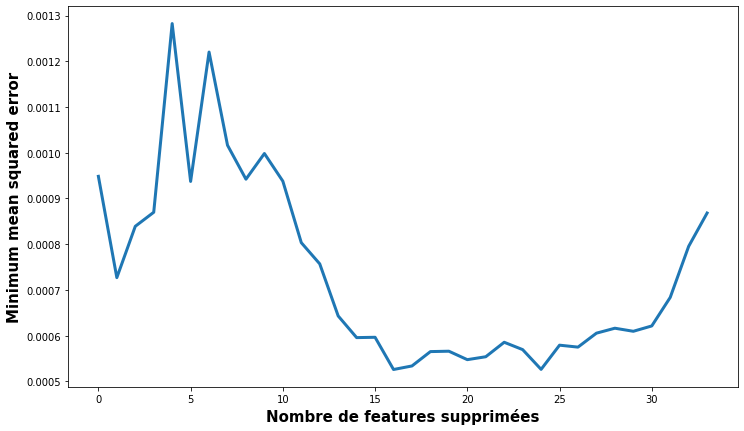

In [ ]:
#Results :
loss_list = [0.0009484026813879609, 0.0007268588524311781, 0.0008390765287913382, 0.0008698136080056429, 0.0012824272271245718, 0.0009372056229040027, 0.001220152829773724, 0.0010163792176172137, 0.0009421258000656962, 0.000998278264887631, 0.0009377713431604207, 0.00080331094795838, 0.0007569493027403951, 0.0006430617650039494, 0.0005956888198852539, 0.0005964265437796712, 0.0005259646568447351, 0.0005337317124940455, 0.0005651283427141607, 0.0005659630405716598, 0.0005474837962538004, 0.0005538806435652077, 0.0005855257622897625, 0.0005694734863936901, 0.0005262618069536984, 0.0005791615694761276, 0.0005749125266447663, 0.0006054250407032669, 0.0006162485806271434, 0.0006095386343076825, 0.0006212224834598601, 0.0006836398970335722, 0.0007953273598104715, 0.0008681084727868438]

features_list = ['surfaceWindGustsKph', 'snowfallCentimeters', 'apparentTemperatureCelsius', 'windChillTemperatureCelsius', 'diffuseHorizontalRadiationWsqm', 'downwardSolarRadiationWsqm', 'directNormalIrradianceWsqm', 'precipitationPreviousHourCentimeters', 'cloudCoveragePercent', 'windDirectionDegrees', 'windSpeedKph', 'surfaceAirPressureKilopascals', 'relativeHumidityPercent', 'surfaceDewpointTemperatureCelsius', 'surfaceTemperatureCelsius', 'y_wgs84_HAR', 'y_wgs84_GOR', 'y_wgs84_CAU', 'y_wgs84_STA', 'y_wgs84_MAS', 'y_wgs84_HVH', 'y_wgs84_HRI', 'x_wgs84_HAR', 'x_wgs84_GOR', 'x_wgs84_CAU', 'x_wgs84_STA', 'x_wgs84_MAS', 'x_wgs84_HVH', 'x_wgs84_HRI', 'SO2_HAR', 'SO2_GOR', 'SO2_CAU', 'SO2_STA', 'SO2_HVH']

plt.figure(figsize=(12,7))
plt.plot(loss_list, linewidth=3)
#plt.xticks(rotation=90)
plt.ylabel('Minimum mean squared error', size = 15, fontweight='bold')
plt.xlabel('Nombre de features supprimées', size=15, fontweight='bold')

Text(0.5, 0, 'Features supprimées')

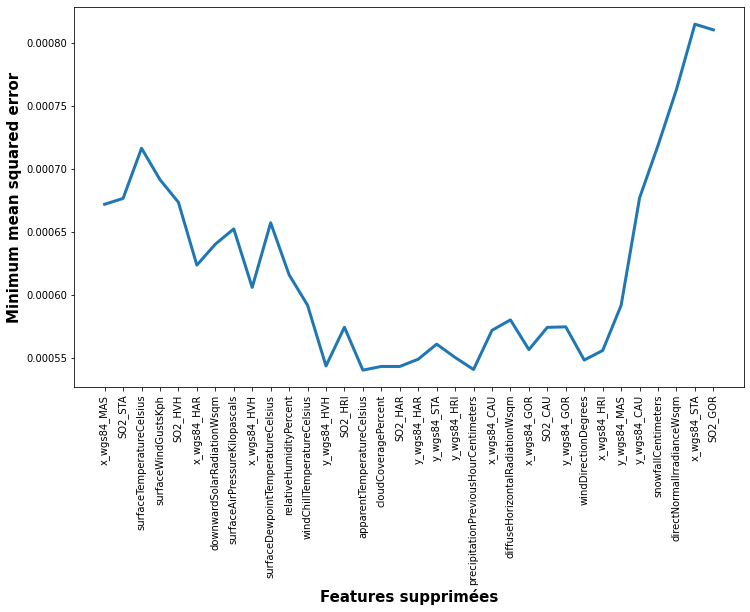

In [ ]:
#2ème exécution en enlevant les bonnes variables
loss_list = [0.0006719765369780362, 0.0006766316946595907, 0.0007164867711253464, 0.0006915455451235175, 0.0006735422648489475, 0.000623631349299103, 0.0006402879953384399, 0.0006524076452478766, 0.0006059429724700749, 0.0006572593119926751, 0.0006159988115541637, 0.000591802760027349, 0.0005435554194264114, 0.0005743263172917068, 0.000540237408131361, 0.0005431611207313836, 0.000543143367394805, 0.0005489356117323041, 0.0005608659121207893, 0.0005503114080056548, 0.0005407457356341183, 0.0005718706524930894, 0.0005801461520604789, 0.0005565296160057187, 0.0005742134526371956, 0.0005746027454733849, 0.0005482322885654867, 0.0005558478878811002, 0.0005917004309594631, 0.0006770265172235668, 0.0007187276496551931, 0.0007632026099599898, 0.0008150196517817676, 0.0008105228189378977] 
features_list = ['x_wgs84_MAS', 'SO2_STA', 'surfaceTemperatureCelsius', 'surfaceWindGustsKph', 'SO2_HVH', 'x_wgs84_HAR', 'downwardSolarRadiationWsqm', 'surfaceAirPressureKilopascals', 'x_wgs84_HVH', 'surfaceDewpointTemperatureCelsius', 'relativeHumidityPercent', 'windChillTemperatureCelsius', 'y_wgs84_HVH', 'SO2_HRI', 'apparentTemperatureCelsius', 'cloudCoveragePercent', 'SO2_HAR', 'y_wgs84_HAR', 'y_wgs84_STA', 'y_wgs84_HRI', 'precipitationPreviousHourCentimeters', 'x_wgs84_CAU', 'diffuseHorizontalRadiationWsqm', 'x_wgs84_GOR', 'SO2_CAU', 'y_wgs84_GOR', 'windDirectionDegrees', 'x_wgs84_HRI', 'y_wgs84_MAS', 'y_wgs84_CAU', 'snowfallCentimeters', 'directNormalIrradianceWsqm', 'x_wgs84_STA', 'SO2_GOR']

plt.figure(figsize=(12,7))
plt.plot(features_list, loss_list, linewidth=3)
plt.xticks(rotation=90)
plt.ylabel('Minimum mean squared error', size = 15, fontweight='bold')
plt.xlabel('Features supprimées', size=15, fontweight='bold')

In [ ]:
#Tuning hyperparamètres

# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop'):
  model_rnn2 = Sequential()
  model_rnn2.add(LSTM(units=30, input_shape= (X_so2.shape[1], X_so2.shape[2]), recurrent_dropout=0.2))
  model_rnn2.add(Dense(units=12))

  model_rnn2.compile(loss='mean_squared_error', optimizer=optimizer)

  return model_rnn2

model = KerasRegressor(model=create_model, verbose=0, loss='mean_squared_error', callbacks=[callback], validation_split=0.08)
print(model.get_params().keys())
# grid search epochs, batch size and optimizer
optimizers = ['rmsprop', 'adam','SGD']
#init = ['glorot_uniform', 'normal', 'uniform']
#epochs = [50, 100, 150]
batches = [10,25,50]
param_grid = dict(optimizer=optimizers, batch_size=batches)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', verbose=3)
grid_result = grid.fit(X_so2, Y_train)
# summarize results

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

NameError: ignored

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
  print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
#Regression logistique pour savoir si la concentration à prédire est nulle
import statsmodels.api as sm

seuil = 0.1

stations1=['HRI', 'HVH', 'STA','CAU','GOR','HAR']
so2_labels=['SO2_' + s + '-' + str(i) for s in stations1 for i in range(48,0,-1)]

'''selected_features_name=['SO2_HRI', 'SO2_HVH', 'SO2_STA', 'SO2_CAU', 'SO2_GOR', 'SO2_HAR', 'windSpeedKph', 'surfaceTemperature','relativeHumidity','surfaceAirPressure','precipitationPreviousHour','directNormalIrradiance','snowfall','surfaceWindGusts'] #features qu'on doit inclure
sf_bool=[any(sf in f for sf in selected_features_name) for f in features]
selected_features=features[[x for x in sf_bool]] #rajouter not pour exclure'''

X_so2= input_train[so2_labels].fillna(value=0).to_numpy()

scaler_x, scaler_y = MinMaxScaler(feature_range=(0, 1)), MinMaxScaler(feature_range=(0, 1))
X_so2=scaler_x.fit_transform(X_so2)

Y_train=output_train.to_numpy()
Y_train_mean=np.array([np.mean(y) for y in Y_train])
Y_train_bool= Y_train_mean<=seuil

log_reg = sm.Logit(Y_train_bool, X_so2).fit()

Optimization terminated successfully.
         Current function value: 0.565122
         Iterations 9


In [ ]:
print(Y_train_bool.shape, np.sum(Y_train_bool))

(6089,) 3089


In [ ]:
#Entraînement d'un modèle random forest lorsque la concentration n'est pas 0 :

from sklearn.ensemble import RandomForestRegressor

X_train= X_so2[[not b for b in Y_train_bool]]
y_train= Y_train[[not b for b in Y_train_bool]]

clf3 = RandomForestRegressor(n_estimators=100, max_features= 10,max_leaf_nodes=50, bootstrap=True)
clf3.fit(X_train, y_train)

X_test_so2= input_test[so2_labels].to_numpy()

Y_class = log_reg.predict(X_test_so2)
Y_class=Y_class.round()

Y_predicted1=clf3.predict(X_test_so2[[not b for b in Y_class]])

Y_predicted=[]
j=0
for i in range(len(Y_class)):
  if Y_class[i]:
    Y_predicted.append([0 for i in range(12)])
  else:
    Y_predicted.append(Y_predicted1[j])
    j+=1
Y_predicted_so2=np.array(Y_predicted)

Y_predicted_labels=['SO2_MAS+' + str(i) for i in range(12)]
Y_predicted_so2_df = pd.DataFrame(Y_predicted_so2, columns=Y_predicted_labels, index= [i for i in range(1, len(Y_predicted_so2)+1)])
Y_predicted_so2_df.index.name='ID'

Y_predicted_so2_df.to_csv('LSTM_so2.csv')

/usr/local/lib/python3.8/dist-packages/statsmodels/discrete/discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


In [ ]:
#Entraînement d'un modèle LSTM lorsque la concentration n'est pas 0 :
X_train = np.reshape(X_so2, (X_so2.shape[0], X_so2.shape[1]//48, 48))
X_train= X_train[[not b for b in Y_train_bool]]

y_train= Y_train[[not b for b in Y_train_bool]]
y_train= scaler_y.fit_transform(y_train)

callback = EarlyStopping(monitor='val_loss', patience=20)

model_rnn = Sequential()
model_rnn.add(LSTM(units=32, input_shape= (X_train.shape[1], X_train.shape[2]), recurrent_dropout=0.2, kernel_regularizer='l2'))
model_rnn.add(Dense(units=12, kernel_regularizer='l2'))
model_rnn.summary()

adam=Adam(learning_rate=0.001)
model_rnn.compile(loss='mean_squared_error', optimizer=adam)

In [ ]:
model_rnn.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.08, callbacks=[callback])

In [ ]:
#Prédiction 
scaler_x1= MinMaxScaler(feature_range=(0, 1))

X_test_so2= input_test[selected_features].to_numpy()
X_test_so2_1=np.reshape(X_test_so2, (X_test_so2.shape[0], X_test_so2.shape[1]//48, 48))

X_test_so2=scaler_x1.fit_transform(X_test_so2)

Y_class = log_reg.predict(X_test_so2)
Y_class=Y_class.round()

Y_predicted_so2=[]

for i in range (len(Y_class)):
  if Y_class[i]:
    Y_predicted_so2.append([0 for i in range(12)])
  else:
    Y_predicted_so2.append(model_rnn.predict(np.array([X_test_so2_1[i]]), verbose =0)[0])

Y_predicted_so2=np.array(Y_predicted_so2)
Y_predicted = scaler_y.inverse_transform(Y_predicted_scaled)

Y_predicted_labels=['SO2_MAS+' + str(i) for i in range(12)]
Y_predicted_so2_df = pd.DataFrame(Y_predicted_so2, columns=Y_predicted_labels, index= [i for i in range(1, len(Y_predicted_so2)+1)])
Y_predicted_so2_df.index.name='ID'

Y_predicted_so2_df.to_csv('LSTM_so2.csv')